<a href="https://colab.research.google.com/github/johnsiphiwe/unsupervised-predict-streamlit-template/blob/master/latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 4.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1623245 sha256=842cf95c983e4fe132d54364d5a9dd8fd2d2308bd06b175949fc095a6cdc1d95
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


Import packages for model evaluation and processing

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import surprise
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import accuracy
from sklearn.datasets import make_blobs
# Import KMeans model
from sklearn.cluster import KMeans
# Import time to measure algorithm runtime 
from time import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Load in the dataset(all the files) with the movie details

In [ ]:
# import dataset
test = pd.read_csv("/content/drive/MyDrive/edsa-movie-recommendation-wilderness/test.csv", low_memory=False)
ratings = pd.read_csv("/content/drive/MyDrive/edsa-movie-recommendation-wilderness/train.csv", low_memory=False)
score = pd.read_csv("/content/drive/MyDrive/edsa-movie-recommendation-wilderness/genome_scores.csv", low_memory=False)
tags = pd.read_csv("/content/drive/MyDrive/edsa-movie-recommendation-wilderness/genome_scores.csv", low_memory=False)
imbd = pd.read_csv("/content/drive/MyDrive/edsa-movie-recommendation-wilderness/imdb_data.csv",low_memory=False)
links = pd.read_csv("/content/drive/MyDrive/edsa-movie-recommendation-wilderness/links.csv", low_memory=False)
movies = pd.read_csv("/content/drive/MyDrive/edsa-movie-recommendation-wilderness/movies.csv",low_memory=False)
tag = pd.read_csv("/content/drive/MyDrive/edsa-movie-recommendation-wilderness/tags.csv",low_memory=False)

Try to get a feel and see how the data is structured for all the dataset

In [ ]:
score.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [ ]:
imbd.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [ ]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


***EDA***


Start to visualize the train dataset, count all the ratings made by the users and how they differ for each category

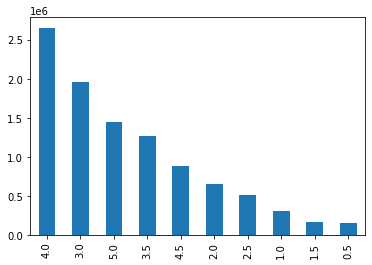

In [ ]:
ratings['rating'].value_counts().plot(kind='bar')

Getting the total number of ratings by the top 10 users, assess how different user ratings contribute to each of the movies likely to be recommended.

In [ ]:
# Total Number of ratings by the top 10 Users
tot_rating = ratings['userId'].value_counts().head(10).sum()
tot_movies = ratings["movieId"].nunique()
print("These Top 10 Users have provided a total of " + str(tot_rating) + " ratings together for " + str(tot_movies) + " movies")

These Top 10 Users have provided a total of 38970 ratings together for 48213 movies


The Average Rating is : 3.5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


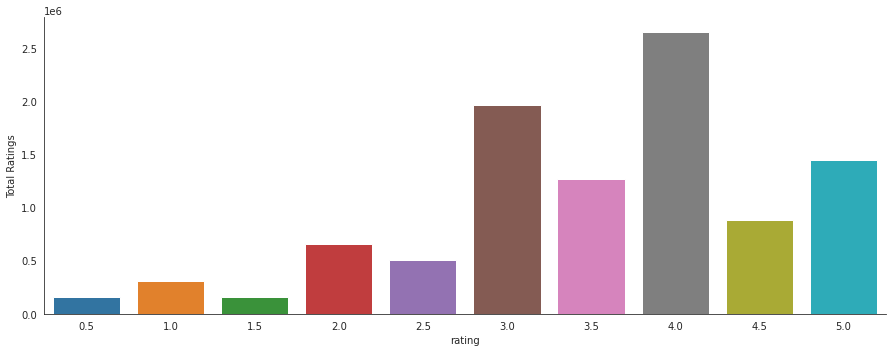

In [ ]:
# print the avarage rating
print (f'The Average Rating is : {round(np.mean(ratings["rating"]),1)}')

# create a catt plot for total ratings
with sns.axes_style('white'):
    plt = sns.catplot("rating", data = ratings, aspect=2.5, kind='count')
    plt.set_ylabels("Total Ratings")

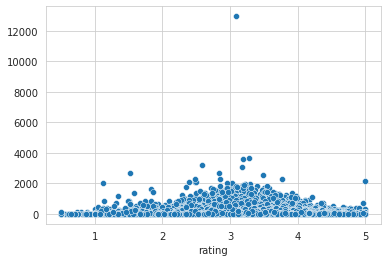

In [ ]:
# create a graph for rating vs users in movies
sns.set_style('whitegrid')

avg_rating = ratings.groupby(ratings['userId'])['rating'].mean()
movie_rated = ratings.groupby(ratings['userId'])['movieId'].count().values

#create scatterplot 
sns.scatterplot(x=avg_rating,y=movie_rated )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


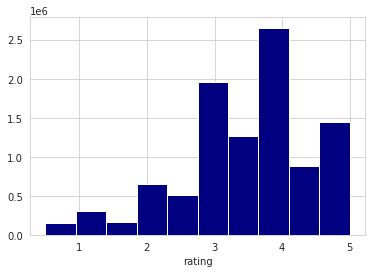

In [ ]:
# create graph for rating add the avarage line
# create a plot 
sns.set_style('whitegrid')

ax = sns.distplot(ratings['rating'], bins=10, kde=False, hist_kws=dict(alpha=1), color="navy")

# use avarage of rating in training dataframe
avg = ratings['rating'].mean()

#create a line for rating avarage
trans = ax.get_xaxis_transform()

In [ ]:
X = ratings.copy()
y = ratings['userId']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [ ]:
#Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

#Function that computes the root mean squared error (or RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
#Define the baseline model to always return 3.
def baseline(user_id, movie_id):
    return 3.0

In [ ]:
#Function to compute the RMSE score obtained on the testing set by a model

def score(cf_model):
    
    #Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(X_test['userId'], X_test['movieId'])
    
    #Predict the rating for every user-movie tuple
    y_pred = np.array([cf_model(user, movie) for (user, movie) in id_pairs])
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['rating'])
    
    #Return the final RMSE score
    return rmse(y_true, y_pred)

In [ ]:
score(baseline)

1.1871781510928132

In [ ]:
# create scaler object
scaler = StandardScaler()

# scale the data
X_scaled = scaler.fit_transform(y_train)

ValueError: ignored

In [ ]:
K = 4
km = KMeans(n_clusters=K, random_state=42)
km.fit(X_scaled)

In [ ]:
y_preds = km.predict(X_scaled)
y_train['cluster_label'] = y_preds
centers = scaler.inverse_transform(km.cluster_centers_)

In [ ]:
# plot data
plt.figure(dpi=120)
for k in range(K):
    x1 = y_train[y_train['cluster_label'] == k]['feature_0']
    x2 = y_train[y_train['cluster_label'] == k]['feature_1']
    plt.scatter(x1, x2, label="k = "+str(k+1))
    
# show cluster centroid locations
plt.scatter(centers[:,0],centers[:,1],label="centroid")


plt.legend()
plt.title("K = 4")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [ ]:
reader = Reader()

In [ ]:
# Load the 100k dataset
#ratings.drop('timestamp',inplace=True)
train_subset = ratings[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = 0.25, random_state=42)

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], Reader())
train_set, test_set = train_test_split(data, test_size=0.20)
svd=SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)

In [ ]:
#Fitting the model
svd.fit(train_set)
# Make predictions
test_pred= svd.test(test_set)
#Evaluate model performance
rsme_collabo = accuracy.rmse(test_pred,verbose=True)

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['rmse', 'mae'])

{'fit_time': (5.404011964797974,
  5.488208532333374,
  5.441411256790161,
  5.52686882019043,
  5.5009496212005615),
 'test_mae': array([0.75949516, 0.76468708, 0.7578069 , 0.7505097 , 0.75543289]),
 'test_rmse': array([0.98374978, 0.98299308, 0.97918331, 0.97093886, 0.9765666 ]),
 'test_time': (0.28302741050720215,
  0.2077319622039795,
  0.1543266773223877,
  0.31812214851379395,
  0.2801244258880615)}

In [ ]:
model = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)
#model.fit(X_train)
predictions = model.test(y_test)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

In [ ]:
svd_sub = SVD()
svd_sub.fit(X_train)
svd_pred = svd_sub.test(y_test)

# Model Preformance

svd_rmse = accuracy.rmse(svd_pred)